# ConSciNet: pendulum

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
% cd /content/drive/MyDrive/ConSciNet_release

/content/drive/MyDrive/ConSciNet_release


In [12]:
import autograd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import autograd.numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp 
from utils.data_loader import *
from utils.training import *
from models.conscinet import *
from utils.pendulum_system import *


## Load data

In [4]:
# load training data
system = 'pendulum' 
data = load_data(system = system, n_to_load = 5)

In [5]:
# setup trial
data = setup_trial(data.copy(), sigma = 0.03)
data_in = data['data_in']

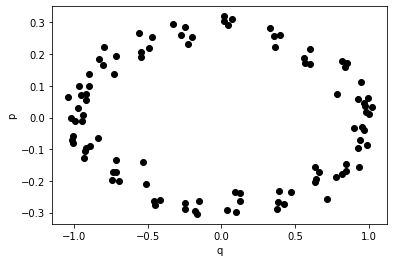

In [47]:
plt.scatter(data['q_with_noies'][0],data['p_with_noies'][0], color = 'black')
plt.xlabel('q')
plt.ylabel('p');

In [6]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load training data
inputs  = torch.Tensor(data['data_in'])
outputs = torch.Tensor(data['qp_dot_with_noies'])

traindata  = TensorDataset(inputs, outputs)
dataloader = DataLoader(traindata, batch_size=256,shuffle=False, num_workers= 1)

## Load models

In [8]:
# Initialize models

latent_dim = 3
aux_dim = 2
n_epochs = 500

# Initialize a baseline SciNet model

encoder = VAEncoder(input_dim = 100, # input trajectory length 50
                    latent_dim = 3, # output latent vector z
                    layer_dim = [500,100]) # ae layer dimensions, same as in SciNet

neural_analog_func_b = MLP(input_dim = latent_dim + aux_dim, # f(z,q,p)
                           hidden_dim   = 10, # layer dimensions
                           output_dim   = 2,  # output size 2 (qdot,pdot)
                           activation_func = nn.Tanh())

b_scinet_3lv03 = ConSciNet(Encoder = encoder, 
                     NAFunc = neural_analog_func_b, 
                     trial = f'Noise_lvl03_Baseline_{system}')


# Initialize a Constrained SciNet model

encoder = VAEncoder(input_dim = 100, # input trajectory length 50
                    latent_dim = latent_dim, # output latent vector z
                    layer_dim = [500,100]) # ae layer dimensions, same as in SciNet

diff_func = MLP(input_dim = latent_dim + aux_dim, # f(z,q,p)
                hidden_dim   = 10, # HNN layer dimensions
                output_dim   = 1,  # output size 1 H*
                activation_func = nn.Tanh())
         
neural_analog_func = HNN(input_dim = 2,
                         differentiable_model = diff_func
                         )

c_scinet_3lv03 = ConSciNet(Encoder = encoder, 
                     NAFunc = neural_analog_func, 
                     trial = f'Noise_lvl03_ConSciNet_{system}')

In [9]:
load_model(b_scinet_3lv03,'models/weights/Noise_lvl03_Baseline_L_0308_pendulum_weights50k_lv3.pt')
load_model(c_scinet_3lv03,"models/weights/Noise_lvl03_ConSciNet_L_0308_pendulum_weights50k_lv3.pt")

<All keys matched successfully>

## Results

In [15]:

def get_lv(model, z_dim):
  z_list = []

  [z_list.append([]) for i in range(z_dim)]

  for i in range(data['x'].shape[0]):
    m = model.encoder(torch.tensor(data_in[i][:-2]).float()) #.detach().numpy()[0]
    latent_vec = model.encoder.mu.detach().numpy()
    [z_list[i].append(latent_vec[i]) for i in range(z_dim)]
  return z_list



In [13]:
def integrate_model(model, t_span, y0, lv,**kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32) #.view(1,2)
        hnn_in = torch.cat([x.squeeze(),lv[0]])
        
        #[(latent,q,p), (q,p)]
        dx = model.nafunc.time_derivative(hnn_in,x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

### Predictions

In [10]:
import pandas as pd

# select sequential values of lengths.
df = pd.DataFrame()
df['length'] = data['length']
df['trials'] = np.arange(len(data['length']))
df = df.sort_values(['length'])
df['key'] = np.arange(len(data['length']))

x = np.round(np.linspace(0,len(data['length']), 4))
x[3] = x[3] - 1
df = df[df['key'].isin(x)]
trial_vals = list(df['trials'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


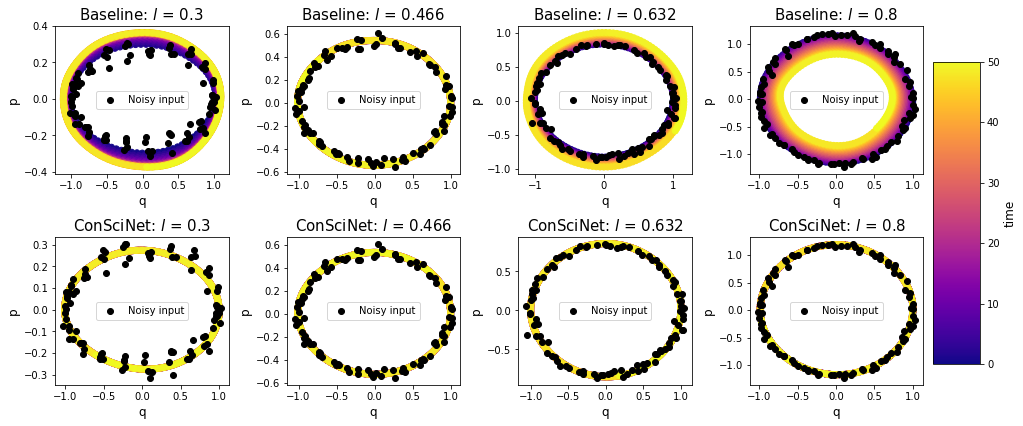

In [14]:
# evaluate at selected length values and plot

share_axis = False
fig, axs = plt.subplots(2, len(trial_vals),figsize=(13,6), sharey= share_axis, sharex= share_axis)
t_span = [0,50]
n_points = 2000 # 100
c_model = c_scinet_3lv03
b_model =  b_scinet_3lv03
y0 = [1,0] # q,p
t_eval = np.linspace(t_span[0], t_span[1], n_points)
kwargs = {'t_eval': t_eval, 'rtol': 1e-12}

for trial_n in range(len(trial_vals)):

  trial = trial_vals[trial_n] #np.random.randint(1,49000)
  length = np.round(data['length'][trial],3)

  c_lv = c_model.encoder(torch.tensor(data_in[trial][:-2]).float())
  b_lv = b_model.encoder(torch.tensor(data_in[trial][:-2]).float())
  lv = c_lv
  c_path = integrate_model(c_model, t_span, y0, lv = c_lv, **kwargs)
  lv = b_lv
  b_path = integrate_model(b_model, t_span, y0,lv = b_lv, **kwargs)



  axs[1][trial_n].scatter(x = c_path['y'][0],y = c_path['y'][1], c = c_path['t'], cmap = 'plasma')
  c = axs[0][trial_n].scatter(x = b_path['y'][0],y = b_path['y'][1], c = b_path['t'], cmap = 'plasma')

  axs[1][trial_n].set_xlabel('q', fontsize = 12)
  axs[1][trial_n].set_ylabel('p', fontsize = 12)
  axs[1][trial_n].set_title(f'ConSciNet: $l$ = {length}', fontsize = 15)
  axs[1][trial_n].scatter(data['q_with_noies'][trial],data['p_with_noies'][trial], color = 'black', label = 'Noisy input')
  axs[1][trial_n].legend()

  axs[0][trial_n].set_xlabel('q', fontsize = 12)
  axs[0][trial_n].set_ylabel('p', fontsize = 12)
  axs[0][trial_n].set_title(f'Baseline: $l$ = {length} ', fontsize = 15);
  axs[0][trial_n].scatter(data['q_with_noies'][trial],data['p_with_noies'][trial], color = 'black', label = 'Noisy input')
  axs[0][trial_n].legend()

cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
fig.colorbar(c, cax=cbar_ax).set_label('time', fontsize = '12')
fig.tight_layout(pad=1.0);

### Latent variable disentanglement

In [16]:
latent_vec_c3lv03 = get_lv(c_scinet_3lv03,z_dim = 3)
latent_vec_b3lv03 = get_lv(b_scinet_3lv03,z_dim = 3)

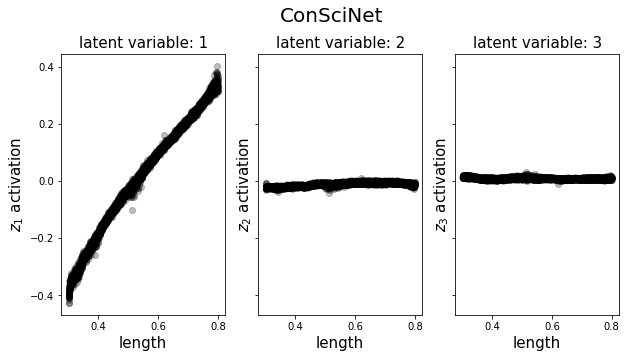

In [17]:
z_list = latent_vec_c3lv03 
n_to_plot = 5000
fig,axs =  plt.subplots(1,len(z_list), sharey= True)

title = "ConSciNet" # pendulum latent vector disentanglement | $\sigma = 0.03$

for i in range(3):
  axs[i].scatter(data['length'][:n_to_plot],z_list[i][:n_to_plot], alpha = 0.25, color = 'black') #rasterized=True
  axs[i].set_title(f'latent variable: {i+1}', fontsize = 15)
  axs[i].set_xlabel('length', fontsize = 15)
  axs[i].set_ylabel(f'$z_{{{i+1}}}$ activation', fontsize = 15) 

fig.set_size_inches(10, 5)

fig.suptitle(title,fontsize = 20);
plt.subplots_adjust(top=0.85, wspace=0.2)

#plt.savefig('Pendulum_conscinet_lv_dis_v3.svg', format='svg',bbox_inches='tight', dpi = 300)
fig.show()

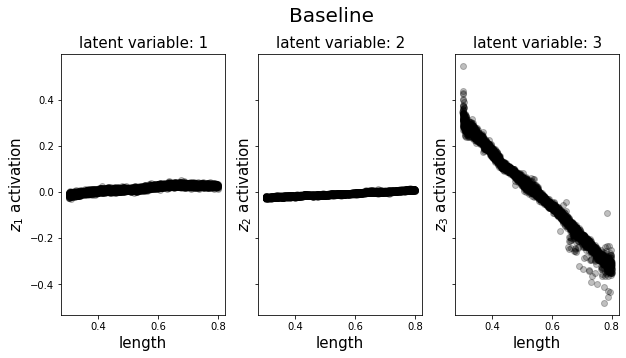

In [18]:
z_list = latent_vec_b3lv03 
n_to_plot = 5000
fig,axs =  plt.subplots(1,len(z_list), sharey= True)

title = "Baseline" # pendulum latent vector disentanglement | $\sigma = 0.03$

for i in range(3):
  axs[i].scatter(data['length'][:n_to_plot],z_list[i][:n_to_plot], alpha = 0.25, color = 'black')
  axs[i].set_title(f'latent variable: {i+1}', fontsize = 15)
  axs[i].set_xlabel('length', fontsize = 15)
  axs[i].set_ylabel(f'$z_{{{i+1}}}$ activation', fontsize = 15) 

fig.set_size_inches(10, 5)

fig.suptitle(title,fontsize = 20);
fig.suptitle(title,fontsize = 20);
plt.subplots_adjust(top=0.85, wspace=0.2)

#plt.savefig('Pendulum_baseline_lv_dis_v3.svg', format='svg',bbox_inches='tight', dpi = 300)
fig.show()

### Interpolation


In [19]:
def lv_interpolation_phase(model1,model2, latent_vec1, latent_vec2, lv_pos1,lv_pos2, n = 5,y0 = [1,0],t_span = [0,10], poly_order = 5, x_range = [1000,2000]):
  z_dim = model1.encoder.latent_dim

  #get postion of min max in training data
  in_length = data['length']
  len_min_idx = np.argmin(in_length)
  len_max_idx = np.argmax(in_length)
  min_input = data['x'][len_min_idx]
  max_input = data['x'][len_max_idx]

  # ODE
  #t_span = [0,20]
  t_eval = np.linspace(t_span[0], t_span[1], 2000)
  kwargs = {'t_eval': t_eval, 'rtol': 1e-12}

  #l_vals = np.linspace(0.3,0.8, n)
  l_vals = np.linspace(np.min(in_length), np.max(in_length), n)
 
  lv_fit1 = np.poly1d(np.polyfit(data['length'],latent_vec1[lv_pos1], deg = poly_order))
  lv_fit2 = np.poly1d(np.polyfit(data['length'],latent_vec2[lv_pos2], deg = poly_order))

  l_like_vals1 = lv_fit1(l_vals)
  l_like_vals2 = lv_fit2(l_vals)

  #ground truth
  gt_paths = []
  for l in l_vals:
    pen_params['l'] = l
    gt_path = solve_ivp(fun=dynamics_fn, 
                            t_span=t_span, 
                            y0=y0, 
                            t_eval=t_eval, 
                            rtol=1e-12)
    gt_paths.append(gt_path)


  c_paths = []

  for lv in l_like_vals1:
    pred = []
    lv_values1 = np.zeros(z_dim)
    lv_values1[lv_pos1] = lv
    #lv_values = [0,lv,0]
    lv_values1 = list(lv_values1)
    lv = torch.tensor([lv_values1]).float()
    c_paths.append(integrate_model(model1, t_span, y0,lv = lv, **kwargs))

  c_paths2 = []
  for lv in l_like_vals2:
    pred = []
    lv_values2 = np.zeros(z_dim)
    lv_values2[lv_pos2] = lv
    lv_values2 = list(lv_values2)
    lv = torch.tensor([lv_values2]).float()
    c_paths2.append(integrate_model(model2, t_span, y0,lv = lv, **kwargs))

  #plot
  fig, axs = plt.subplots(1, n,figsize=(20,5), sharey= True, sharex = True)
  for i in range(n):
    axs[i].plot(gt_paths[i]['y'][0], gt_paths[i]['y'][1], color = 'black', label = 'Ground truth')
    axs[i].plot(c_paths[i]['y'][0],c_paths[i]['y'][1], color = 'blue', label = 'ConSciNet')
    axs[i].plot(c_paths2[i]['y'][0],c_paths2[i]['y'][1], color = 'red',label = 'Baseline')

    axs[i].set_ylabel('p', fontsize = 15)
    axs[i].set_xlabel('q', fontsize = 15)
    axs[i].legend(loc = 'best')
    
  plt.setp(axs, xlim= [-1.25, 1.25])
  plt.setp(axs, ylim= [-1.25, 1.25])
  plt.subplots_adjust(top=0.8, wspace=0.09)
  plt_title = f'Pendulum latent variable interpolation | tspan = {t_span}' + '\n $l_{min}^*$ $\longrightarrow$  $l_{max}^*$'
  
  fig.suptitle(plt_title, fontsize = 20);
  #plt.savefig('Pendulum_ConSciNet_Phase.svg', format='svg',bbox_inches='tight', dpi = 300)

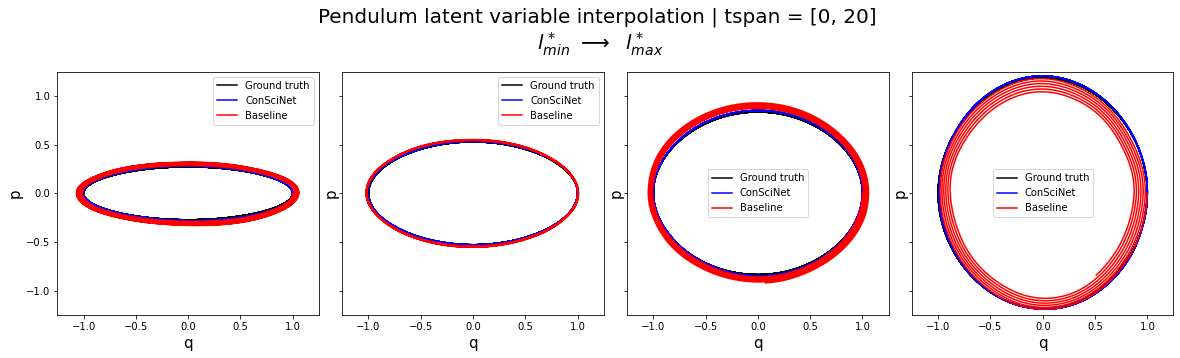

In [20]:
t_span = [0,20]
poly_order = 3
lv_interpolation_phase(model1 =  c_scinet_3lv03,
                    model2 = b_scinet_3lv03, 
                    latent_vec1 = latent_vec_c3lv03, 
                    latent_vec2 =  latent_vec_b3lv03,
                    lv_pos1 = 0,
                    lv_pos2 = 2, n = 4, 
                    t_span = t_span,
                    poly_order = poly_order, x_range = [0,1000])

In [21]:
def lv_interpolation_time(model1,model2, latent_vec1, latent_vec2, lv_pos1,lv_pos2, n = 5,y0 = [1,0],t_span = [0,10], poly_order = 5, x_range = [1000,2000]):
  z_dim = model1.encoder.latent_dim

  #get postion of min max in training data
  in_length = data['length']
  len_min_idx = np.argmin(in_length)
  len_max_idx = np.argmax(in_length)
  min_input = data['x'][len_min_idx]
  max_input = data['x'][len_max_idx]

  # ODE
  #t_span = [0,20]
  t_eval = np.linspace(t_span[0], t_span[1], 2000)
  kwargs = {'t_eval': t_eval, 'rtol': 1e-12}

  l_vals = np.linspace(np.min(in_length) + 0.1, np.max(in_length), n)
 
  lv_fit1 = np.poly1d(np.polyfit(data['length'],latent_vec1[lv_pos1], deg = poly_order))

  lv_fit2 = np.poly1d(np.polyfit(data['length'],latent_vec2[lv_pos2], deg = poly_order))

  l_like_vals1 = lv_fit1(l_vals)
  l_like_vals2 = lv_fit2(l_vals)

  #ground truth
  gt_paths = []
  for l in l_vals:
    pen_params['l'] = l
    gt_path = solve_ivp(fun=dynamics_fn, 
                            t_span=t_span, 
                            y0=y0, 
                            t_eval=t_eval, 
                            rtol=1e-12)
    gt_paths.append(gt_path)


  c_paths = []

  for lv in l_like_vals1:
    pred = []
    lv_values1 = np.zeros(z_dim)
    lv_values1[lv_pos1] = lv
    lv_values1 = list(lv_values1)
    lv = torch.tensor([lv_values1]).float()
    c_paths.append(integrate_model(model1, t_span, y0,lv = lv, **kwargs))

  c_paths2 = []
  for lv in l_like_vals2:
    pred = []
    lv_values2 = np.zeros(z_dim)
    lv_values2[lv_pos2] = lv
    lv_values2 = list(lv_values2)
    lv = torch.tensor([lv_values2]).float()
    c_paths2.append(integrate_model(model2, t_span, y0,lv = lv, **kwargs))

  #plot
  fig, axs = plt.subplots(1, n,figsize=(20,5), sharey= True, sharex = True)
  for i in range(n):
    axs[i].plot(t_eval, gt_paths[i]['y'][0], color = 'black', label = 'Ground truth')
    axs[i].plot(t_eval,c_paths[i]['y'][0], color = 'blue', label = 'ConSciNet')
    axs[i].plot(t_eval,c_paths2[i]['y'][0], color = 'red',label = 'Baseline')
    axs[i].set_ylabel('q', fontsize = 15)
    axs[i].set_xlabel('t', fontsize = 15)
    axs[i].legend(loc = 'best')
  
  plt.setp(axs, ylim= [-1.25, 1.8])
  plt.subplots_adjust(top=0.8, wspace=0.09)
  plt_title = f'Pendulum latent variable interpolation | tspan = {t_span}' + '\n $l_{min}^*$ $\longrightarrow$  $l_{max}^*$'
  
  fig.suptitle(plt_title, fontsize = 20);
  #plt.savefig('Pendulum_ConSciNet_time.svg', format='svg',bbox_inches='tight', dpi = 300)

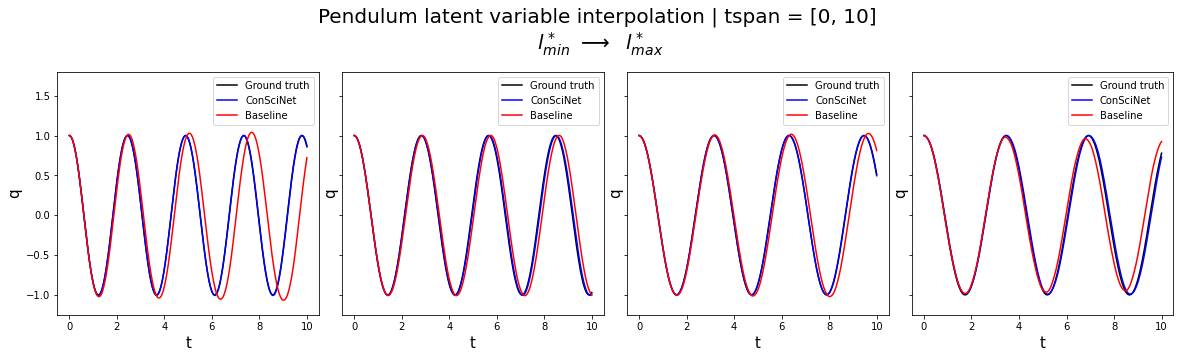

In [22]:
t_span = [0,10]
poly_order = 3
lv_interpolation_time(model1 =  c_scinet_3lv03,
                    model2 = b_scinet_3lv03, 
                    latent_vec1 = latent_vec_c3lv03, 
                    latent_vec2 =  latent_vec_b3lv03,
                    lv_pos1 = 0,
                    lv_pos2 = 2, 
                    n = 4, 
                    t_span = t_span,
                    poly_order = poly_order, x_range = [0,1000])